# Notebook Purpose



This notebook implemented my architecture using Pytorch. However, because I ran into unexpected results with the Pytorch implementation of Earth Mover's Distance, I decided to implement using Keras. I attach this notebook to demonstrate progress and effort.

(These cells will not run perfectly because I stopped working on the Pytorch implementation, but you can see that I built out the same architecture here.


# Import dependencies

In [1]:
import time
import numpy as np
import torch
from torch import nn
from torch.autograd import Function
#must compile emd
import emd
import emd_module
from emd_module import emdModule
import pickle

from torch import optim
import gc
import torchvision
from torch.autograd import Variable
import pickle
import numpy as np
import random
random.seed(1)


Input_size:  torch.Size([20, 8192, 3])
Runtime: 0.627515s
EMD: 0.046405
|set(assignment)|: 8192
Verified EMD: 0.046405


@author emd https://github.com/Colin97/MSN-Point-Cloud-Completion

# Import data

In [52]:
synthetic_pairs = np.load('../data/norm_synthetic_ptclouds.npz')['array1']
synthetic_params = np.load('../data/norm_synthetic_params.npz')['array1']
real_ptclouds = np.load('../data/norm_real_ptclouds.npz')['array1']

In [108]:
real_ptclouds = real_ptclouds.repeat((int(synthetic_pairs.shape[1]/real_ptclouds.shape[0])),axis=0)
real_ptclouds = np.expand_dims(real_ptclouds,0)
synthetic_pairs = synthetic_pairs[:,:real_ptclouds.shape[1],:,:]
ptcloud_trios = np.vstack([synthetic_pairs,real_ptclouds])

synthetic_params = np.expand_dims(np.expand_dims(synthetic_params,2),2)

train_ptclouds = np.expand_dims(ptcloud_trios,3)
train_params = synthetic_params[:,:train_ptclouds.shape[1],:,:,:]


In [15]:
num_ptclouds = int(real_ptclouds.shape[0] * 0.8)
ptcloud_trios = [[real_ptclouds[i], synthetic_ptcloud_pairs[i][0], synthetic_ptcloud_pairs[i][1]] for i in range(0,num_ptclouds)]
ptcloud_trios = np.array(ptcloud_trios)

ptcloud_trios = Variable(torch.from_numpy(ptcloud_trios).float(), requires_grad=True)


# Set up architecture

In [17]:
class Encoder(nn.Module):
    #Takes in n x c x features
    def __init__(self, ptcloud_size, num_semantic_param):
        super(Encoder, self).__init__()
        self.ptcloud_size = ptcloud_size
        self.num_semantic_params = num_semantic_param
        
        self.emd_function = emd_module.emdModule()
        sequence = [
            torch.nn.Conv1d(3,64,1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(64),
            torch.nn.Conv1d(64,128,1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Conv1d(128, 128,1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),  
            torch.nn.Conv1d(128, 256, 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),  
            torch.nn.Conv1d(256, self.num_semantic_params, 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(self.num_semantic_params),
            torch.nn.Conv1d(self.num_semantic_params, self.num_semantic_params, 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(self.num_semantic_params),
            torch.nn.Conv1d(self.num_semantic_params, self.num_semantic_params, 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(self.num_semantic_params),
            torch.nn.MaxPool1d(kernel_size=self.ptcloud_size)
        ]
        self.main = nn.Sequential(*sequence)

    def forward(self, input):
        return self.main(input)



class Decoder(nn.Module):
    
    def __init__(self, ptcloud_size, num_semantic_param):
        super(Decoder, self).__init__()
        self.ptcloud_size = ptcloud_size
        self.num_semantic_param = num_semantic_param
        self.conv1= torch.nn.Conv1d(in_channels=self.num_semantic_param, out_channels=1024, kernel_size=1)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=1)
        self.relu2 = torch.nn.ReLU()
        self.flatten1 = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=2048, out_features=6144)
        self.relu3 = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten1(x)
        x = self.linear1(x)
        x = self.relu3(x)
        return x


In [18]:
class SemanticSpaceNet(nn.Module):
    def __init__(self, num_features, batch_size,perturbation = 0.2):
        super(SemanticSpaceNet, self).__init__()
        
        self.encoder = Encoder(2048,6).float().cuda()
        self.decoder = Decoder(2048,6).float().cuda()
        self.encoded_real = None

        self.num_features = num_features
        self.batch_size = batch_size
        return

    def forward(self,ptcloud_trio):
        self.real_x = ptcloud_trio[:,0]
        self.fake_edit_x = ptcloud_trio[:,1]
        self.fake_x = ptcloud_trio[:,2]

        self.encoded_real = semantic_net.encoder.forward(self.real_x)
        self.encoded_fake = semantic_net.encoder.forward(self.fake_x)
        self.encoded_fake_edit = semantic_net.encoder.forward(self.fake_edit_x)

        self.decoded_real = semantic_net.decoder.forward(self.encoded_real).view(self.batch_size, 2048,3)
        self.decoded_fake = semantic_net.decoder.forward(self.encoded_fake).view(self.batch_size, 2048,3)
        self.decoded_fake_edit = semantic_net.decoder.forward(self.encoded_fake_edit).view(self.batch_size, 2048,3)
    def mse(self,semantic_labels):

        mse = torch.nn.MSELoss()
        semantic_base_loss=mse(self.encoded_fake,semantic_labels[:,:,:1])
        semantic_edit_loss=mse(self.encoded_fake_edit,semantic_labels[:,:,:-1])
        semantic_loss = (semantic_base_loss + semantic_edit_loss).float()
        return semantic_loss

    def emd(self):
        emd_func = emdModule()
        
        #real to real reconstruction
        real2real_emd_loss,_ = emd_func.forward(self.decoded_fake, self.fake_x.transpose(-1,-2), 0.05, 3000)
        real2real_emd_loss = torch.sqrt(real2real_emd_loss).mean(1).sum()

        #fake to fake reconstruction
        fake2fake_emd_loss,_ = emd_func.forward(self.decoded_fake_edit, self.fake_edit_x.transpose(-1,-2), 0.05, 3000)
        fake2fake_emd_loss = torch.sqrt(fake2fake_emd_loss).mean(1).sum()

        #real to fake similarity
        # get data from blender script
        real2fake_similarity_loss,_ = emd_func.forward(self.decoded_real, self.real_x.transpose(-1,-2), 0.05, 3000)
        real2fake_similarity_loss = torch.sqrt(real2fake_similarity_loss).mean(1).sum()
        
        return real2real_emd_loss + fake2fake_emd_loss, real2fake_similarity_loss


In [19]:

train_val_split = 0.8
    
def net_loss(mse_loss, emd_loss , similarity_loss,alpha=0.03, beta=4, gamma=0.5):
    return (alpha * mse_loss) + (beta * emd_loss) + (gamma * similarity_loss)


pass in the trios of data

In [20]:
semantic_labels = np.array([synthetic_param_pairs[i] for i in range(0, num_ptclouds)])
semantic_param_label = semantic_labels
semantic_param_label = Variable(torch.from_numpy(semantic_param_label).float(), requires_grad=True)

In [21]:
batch_size = 32
semantic_net = SemanticSpaceNet(6, batch_size).float()
batch_losses = []
epoch_losses = []

# Begin Training Loop

In [23]:
import time
import gc
import torchvision
from torch.autograd import Variable

start = time.time()

semantic_net.train()
optimizer = optim.Adam(semantic_net.parameters(), lr=0.001)
#1,10,20,20
epochs = 30

if torch.cuda.is_available():
    semantic_net.cuda()

X = ptcloud_trios
y = semantic_param_label 
mse = torch.nn.MSELoss()
emd_func = emdModule()
num_batches = int(X.shape[0] /batch_size)

for epoch in range(epochs):
    batch_losses=[]

    min_so_far = 100000
    for batch_index in range(0, num_batches):

        current_train_x = X[batch_index*batch_size:(batch_index+1)*batch_size].transpose(-1,-2).cuda(non_blocking=True)
    
        current_train_y = y[batch_index*batch_size:(batch_index+1)*batch_size].transpose(-1,-2).cuda(non_blocking=True)
      
        optimizer.zero_grad()
      
        semantic_net.forward(current_train_x)

        criterion_semantic = semantic_net.mse(current_train_y)
        
        criterion_reconstruction, criterion_similarity = semantic_net.emd()

        train_loss = net_loss(criterion_semantic, criterion_reconstruction, criterion_similarity)
        batch_losses.append(train_loss.item())
        
        train_loss.backward()

        optimizer.step()
        
        if train_loss.item() < min_so_far:
            min_so_far = train_loss.item()
            
        if batch_index % 100 == 0:
            torch.save(semantic_net.state_dict(), './semanticnet1_'+ str(batch_index))
        

    epoch_losses.append(sum(batch_losses)/batch_size)
    print(epoch_losses[-1])
    gc.collect()
    torch.cuda.empty_cache()

    print("elapsed " + str(time.time() - start) + " seconds")

# End timing how long training takes.
end = time.time()

print( "time taken is "  + str(end - start) + " seconds")
print('Finished Training')

1268.5704951286316
elapsed 255.0937008857727 seconds
1135.115252494812
elapsed 476.54957842826843 seconds
1067.5295734405518
elapsed 685.7895965576172 seconds
989.7583849430084
elapsed 884.2809319496155 seconds
947.7471895217896
elapsed 1074.7624838352203 seconds
907.6206612586975
elapsed 1264.7599704265594 seconds
868.5783548355103
elapsed 1450.3862545490265 seconds
834.3589489459991
elapsed 1632.4972012043 seconds
806.4880127906799
elapsed 1811.4903964996338 seconds
792.6106204986572
elapsed 1989.4802622795105 seconds
780.6532258987427
elapsed 2167.6879596710205 seconds
768.59699177742
elapsed 2344.284481048584 seconds
760.1641871929169
elapsed 2520.0523450374603 seconds
750.0337612628937
elapsed 2693.8469116687775 seconds
738.4557123184204
elapsed 2867.192292690277 seconds
728.6578977108002
elapsed 3040.5925908088684 seconds
717.3473832607269
elapsed 3213.636586666107 seconds
712.221437215805
elapsed 3385.715391635895 seconds
704.4400022029877
elapsed 3561.8086438179016 seconds
697.

# Export to ONNX format

In [2]:
import io
from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

In [24]:
semantic_net.decoder.eval()

Decoder(
  (conv1): Conv1d(6, 1024, kernel_size=(1,), stride=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(1024, 2048, kernel_size=(1,), stride=(1,))
  (relu2): ReLU()
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2048, out_features=6144, bias=True)
  (relu3): ReLU()
)

implement early stopping

In [35]:


class Decoder(nn.Module):
    
    def __init__(self, ptcloud_size, num_semantic_param):
        super(Decoder, self).__init__()
        self.ptcloud_size = ptcloud_size
        self.num_semantic_param = num_semantic_param
        self.conv1= torch.nn.Conv1d(in_channels=self.num_semantic_param, out_channels=1024, kernel_size=1)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(in_channels=1024, out_channels=2048, kernel_size=1)
        self.relu2 = torch.nn.ReLU()
        self.flatten1 = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=2048, out_features=6144)
        self.relu3 = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten1(x)
        x = self.linear1(x)
        x = self.relu3(x)
        return x


# Input to the model
decoder_input = torch.randn(1,6, 1, requires_grad=True).cuda()
decoder_out = semantic_net.decoder(decoder_input).cuda()

# Export the model
torch.onnx.export(semantic_net.decoder,               # model being run
                  decoder_input,                         # model input (or a tuple for multiple inputs)
                  "decoder_export_test4.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['conv1'],   # the model's input names
                  output_names = ['relu3'])# the model's output names

In [24]:
torch.save(semantic_net.state_dict(), './semantic_net_50epochs_77loss')

In [9]:
batch_size=32
model = semantic_net = SemanticSpaceNet(6, batch_size).float()
model.load_state_dict(torch.load('semanticnet2_200'))
model.eval()

SemanticSpaceNet(
  (encoder): Encoder(
    (emd_function): emdModule()
    (main): Sequential(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (4): ReLU()
      (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (7): ReLU()
      (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (10): ReLU()
      (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): Conv1d(256, 6, kernel_size=(1,), stride=(1,))
      (13): ReLU()
      (14): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (15): Conv1d(6, 6, kernel_size=(1,), stride=(1,))
      (

In [27]:
X_test = np.zeros((1,6,1))
X_test[0,:,0] = np.array([0.5,0.2,0,0.2,0,0.2])


In [28]:
decoded = semantic_net.decoder.forward(torch.from_numpy(X_test).cuda().float())

In [29]:
decoded = decoded.reshape((2048,3))

In [25]:
import matplotlib
from matplotlib import pyplot as plt
def plot_3d_point_cloud(x, y, z, show=True, show_axis=True, in_u_sphere=False, marker='.', s=8, alpha=.8, figsize=(5, 5), elev=10, azim=240, axis=None, title=None, *args, **kwargs):

    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')        
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        miv = 0.7 * np.min([np.min(x), np.min(y), np.min(z)])  # Multiply with 0.7 to squeeze free-space.
        mav = 0.7 * np.max([np.max(x), np.max(y), np.max(z)])
        ax.set_xlim(miv, mav)
        ax.set_ylim(miv, mav)
        ax.set_zlim(miv, mav)
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if 'c' in kwargs:
        plt.colorbar(sc)

    if show:
        plt.show()

    return fig

def plot_ptcloud(points):
    plot_3d_point_cloud(points[:,0], points[:,1], points[:,2])

# Example of weird results using Pytorch Earth Mover's Distance

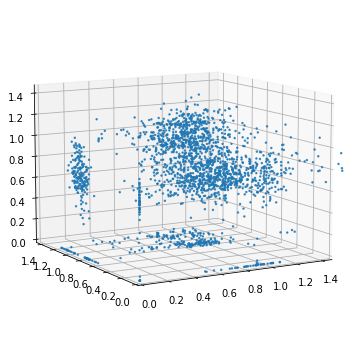

In [34]:
plot_ptcloud(decoded.cpu().detach().numpy())

# Example of training data 

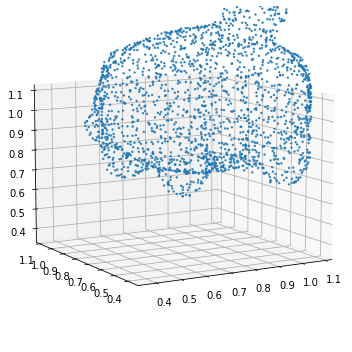

In [44]:
plot_ptcloud(synthetic_ptclouds[30])

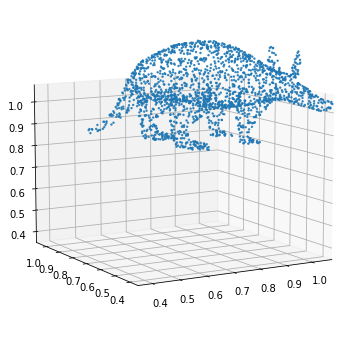

In [43]:
plot_ptcloud(real_ptclouds[0])